# Obtener Especies de Arbotag API y Preparar Dataset de Clasificación

Este cuaderno describe los pasos necesarios para que dada una carpeta con imágenes cuyos nombres contengan el ID de Arbotag, se posible obtener sus datos asociados a la especie de cada árbol, para luego ordenar un dataset de clasificación de géneros de arboles (separado y distribuido en carpetas Train, Validation, Test)

In [2]:
# Importamos algunas dependencias
import requests
import json
import os
import numpy as np
import cv2

images_path = 'C:/Users/jflir/Documents/Arbocensus/ArbocensusData/images/20240723_25'
Api_url = 'https://arbotag.apisaltala.com/tree/getScannedTree'
output_data_file = 'tree_species_data.json'
output_data_file_path = os.path.join(images_path + '/..', output_data_file)


In [2]:
# removemos las imágenes con errores, cuando pesan 0 bytes o son completamente negras o blancas
def remove_images_with_errors(images_path, json_file_path=None):
    for image in os.listdir(images_path):
        image_path = os.path.join(images_path, image)
        if os.path.getsize(image_path) == 0:
            os.remove(image_path)
            print(f"Removed {image_path}")
        try:
            image_path = os.path.join(images_path, image)
            img = cv2.imread(image_path)
            avg_color_per_row = np.average(img, axis=0)
            avg_color = np.average(avg_color_per_row, axis=0)
            if avg_color[0] < 10 and avg_color[1] < 10 and avg_color[2] < 10:
                os.remove(image_path)
                remove_item_from_json_file(json_file_path, image.split('-')[0])
                print(f"Removed {image_path}")
            if avg_color[0] > 245 and avg_color[1] > 245 and avg_color[2] > 245:
                os.remove(image_path)
                remove_item_from_json_file(json_file_path, image.split('-')[0])
                print(f"Removed {image_path}")
        except:
            os.remove(image_path)
            remove_item_from_json_file(json_file_path, image.split('-')[0])
            print(f"error {image_path}")

def remove_item_from_json_file(json_file_path, item):
    if json_file_path is not None:
        with open(json_file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        try:
            data.pop(item)
            with open(json_file_path, 'w', encoding='utf-8') as f:
                json.dump(data, f, ensure_ascii=False)
        except:
            print(f"Already removed {item} from {json_file_path}")

remove_images_with_errors(images_path)

Removed C:/Users/jflir/Documents/Arbocensus/ArbocensusData/images/20240723_25\101171-0.jpg
Removed C:/Users/jflir/Documents/Arbocensus/ArbocensusData/images/20240723_25\115882-0.jpg
Removed C:/Users/jflir/Documents/Arbocensus/ArbocensusData/images/20240723_25\115972-0.jpg
Removed C:/Users/jflir/Documents/Arbocensus/ArbocensusData/images/20240723_25\116034-0.jpg
Removed C:/Users/jflir/Documents/Arbocensus/ArbocensusData/images/20240723_25\116090-1.jpg
Removed C:/Users/jflir/Documents/Arbocensus/ArbocensusData/images/20240723_25\119520-0.jpg
Removed C:/Users/jflir/Documents/Arbocensus/ArbocensusData/images/20240723_25\119719-0.jpg
Removed C:/Users/jflir/Documents/Arbocensus/ArbocensusData/images/20240723_25\119891-0.jpg
Removed C:/Users/jflir/Documents/Arbocensus/ArbocensusData/images/20240723_25\134791-0.jpg
Removed C:/Users/jflir/Documents/Arbocensus/ArbocensusData/images/20240723_25\134819-0.jpg
Removed C:/Users/jflir/Documents/Arbocensus/ArbocensusData/images/20240723_25\135999-0.jpg

### Arbotag - getScannedTree endpoint
Revisando la aplicación web disponible en [arbotag.nunoa.cl](https://arbotag.nunoa.cl/), fue posible identificar un endpoint para obtener los datos de cada árbol por ID. Este sigue la siguiente estructura:

``` POST
URL = https://arbotag.apisaltala.com/tree/getScannedTree
Headers = Content-Type application/json; charset=utf-8
Body = { 
	"treeId": "MY_ID":string, 
	"isWebRequest": true
}
```

### Obtener Ids de las Imágenes y Preparamos la Request

In [3]:
def get_image_ids(images_path):
    image_ids = []
    for root, dirs, files in os.walk(images_path):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png') and '-' in file:
                image_ids.append(file)
    return image_ids

def get_tree_data(image_id):
    data = {
        'treeId': image_id.split('-')[0],
        "isWebRequest": True
    }
    response = requests.post(Api_url, data=data)
    return response.json()

image_ids = get_image_ids(images_path)
print(image_ids[:10])
get_tree_data(image_ids[0])

['100574-0.jpg', '10082-0.jpg', '100859-0.jpg', '100897-0.jpg', '101069-0.jpg', '10107-0.jpg', '101151-0.jpg', '101167-0.jpg', '101169-0.jpg', '101179-0.jpg']


{'success': True,
 'result': {'tree': {'id': '100574',
   'address': 'Avenida Plaza, 2218',
   'lastMaintenance': 'N/D',
   'hasRequestButton': True,
   'unitId': 1,
   'logoUrl': 'https://logos-clientes-saltala.s3-us-west-2.amazonaws.com/arbotag/las_condes.svg',
   'specie': {'name': 'Tilo',
    'scientificName': 'Tilia sp.',
    'geographyOrigin': 'Europa',
    'kind': 'Exótico',
    'clasification': 'Caduco',
    'family': 'Malvaceae',
    'description': 'Es una especie de gran tamaño, que puede alcanzar los 30 m de altura. Sus hojas son características por su diseño acorazonado. Es un árbol muy longevo, alcanzando los mil años. Se considerada como una especie de interés melífero alto para la producción de miel de abeja (Apis melifera). ',
    'sunRequirement': 'Sol',
    'waterRequirement': 'Medio',
    'growthSpeed': 'Rápido',
    'topShape': 'Ovoidal',
    'url': 'https://arbotagfiles.s3.sa-east-1.amazonaws.com/imgspecies/193.jpg'},
   'phytosanitaryState': {'description': 'No ap

### Preparamos una estructura de datos para guardar los datos asociados a la especie de cada arbol y su DAP

``` JSON
{
    100574-0.jpg: {
        'gender': 'Tilo', // El 'name' entregado por arbotag 
        'scientificName': 'Tilia sp.',
        'geographyOrigin': 'Europa',
        'kind': 'Exótico',
        'family': 'Malvaceae',
        'topShape': 'Ovoidal',
        'dap': {'description': 'De 10 a 20 cm'},
    },

    100897-0.jpg: {
        'gender': 'Liquidámbar', // El 'name' entregado por arbotag 
        'scientificName': 'Liquidambar styraciflua L.',
        'geographyOrigin': 'Norteamérica',
        'kind': 'Exótico',
        'family': 'Hamamelidaceae',
        'topShape': 'Cónica',
        'dap': {'description': 'De 20 a 30 cm'},
    },
    ...
}

```

luego los datos de cada ID quedaran almacenados en un archivo .json para trabajar en el dataset de imágenes (`output_data_file`). 

In [15]:
def format_data(json_response, image_id):
    tree_data = json_response['result']['tree']
    specie_data = tree_data['specie']
    dap_data = tree_data['dap']

    transformed_data = {
        image_id: {
            'gender': specie_data['name'],
            'scientificName': specie_data['scientificName'],
            'geographyOrigin': specie_data['geographyOrigin'],
            'kind': specie_data['kind'],
            'family': specie_data['family'],
            'topShape': specie_data['topShape'],
            'dap': dap_data
        }
    }
    return transformed_data

def generate_data_file(image_ids, output_data_file):
    data = {}
    current_image = 0
    for image_id in image_ids:
        try:
            tree_data = get_tree_data(image_id)
            formatted_data = format_data(tree_data, image_id)
            data.update(formatted_data)
            print(f'Processed image {current_image + 1}/{len(image_ids)}')
        except Exception as e:
            print(f'Error processing image {image_id}: {e}')
        current_image += 1
    with open(output_data_file, 'w', encoding='utf-8') as f:
        json.dump(data, f, indent=4, ensure_ascii=False)

generate_data_file(image_ids, output_data_file_path)

Processed image 1/9879
Processed image 2/9879
Processed image 3/9879
Processed image 4/9879
Processed image 5/9879
Processed image 6/9879
Processed image 7/9879
Processed image 8/9879
Processed image 9/9879
Processed image 10/9879
Processed image 11/9879
Processed image 12/9879
Processed image 13/9879
Processed image 14/9879
Processed image 15/9879
Processed image 16/9879
Processed image 17/9879
Processed image 18/9879
Processed image 19/9879
Processed image 20/9879
Processed image 21/9879
Processed image 22/9879
Processed image 23/9879
Processed image 24/9879
Processed image 25/9879
Processed image 26/9879
Processed image 27/9879
Processed image 28/9879
Processed image 29/9879
Processed image 30/9879
Processed image 31/9879
Processed image 32/9879
Processed image 33/9879
Processed image 34/9879
Processed image 35/9879
Processed image 36/9879
Processed image 37/9879
Processed image 38/9879
Processed image 39/9879
Processed image 40/9879
Processed image 41/9879
Processed image 42/9879
P

: 

### Analizar los Datos Recibidos

Como se trabaja con una amplia gama de especies de arboles es necesario estudiar la distribución de nuestros diferentes parámetros, es decir cuantas muestras tenemos por cada clase teórica. Siendo lo ideal trabajar con un numero considerable de muestras por clase, antes de entrenar nuestro clasificador debemos elegir el parámetro que va a representar mejor nuestra población.

In [3]:
def read_data_file(output_data_file):
    with open(output_data_file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

def get_parameters_count(data):
    unique_parameters = {}
    parameters= {}
    for tree_id, tree_data in data.items():
        for parameter, value in tree_data.items():
            if parameter not in unique_parameters.keys():
                unique_parameters[parameter] = [value]
                parameters[parameter] = [value]
            else:
                parameters[parameter].append(value)
                if value not in unique_parameters[parameter]:
                    unique_parameters[parameter].append(value)
    parameters_count = {parameter: len(values) for parameter, values in unique_parameters.items()}
    return unique_parameters , parameters_count, parameters

data = read_data_file(output_data_file_path)
unique_parameters, parameters_count, parameters = get_parameters_count(data)
print(f"""number of tree images: {len(data)}
unique parameters count: {parameters_count}
parameters: 
    gender: {unique_parameters['gender']},
    scientificName: {unique_parameters['scientificName']},
    geographyOrigin: {unique_parameters['geographyOrigin']},
    kind: {unique_parameters['kind']},
    family: {unique_parameters['family']},
    topShape: {unique_parameters['topShape']},
    dap: {unique_parameters['dap']}
""")

number of tree images: 9693
unique parameters count: {'gender': 139, 'scientificName': 138, 'geographyOrigin': 57, 'kind': 3, 'family': 45, 'topShape': 11, 'dap': 11}
parameters: 
    gender: ['Tilo', 'Acer Negundo', 'Jacaranda', 'Liquidámbar', 'Tulipero', 'Acer Japonico', 'Peumo', 'Thuja sp.', 'Mioporo', 'Árbol de Judea', 'Crespón', 'Maitén', 'Melia', 'Ginkgo', 'Ciruelo de Flor [ant]', 'Quillay', 'Ligustro', 'Abedul', 'Almez', 'Fresno Europeo', 'Sofora', 'Ciruelo Rojo', 'Pimiento', 'Olivo', 'Falso Acacio', 'Patagua', 'Pata de vaca', 'Catalpa', 'Palmera Fenix', 'Grevillea', 'Palma Mexicana', 'No aplica', 'Pitosporo nigricans', 'Falso Platano', 'Damasco', 'Olmo', 'Ailanto', 'Especie no identificada', 'Algarrobo Europeo', 'Morera', 'Cedro del Atlas', 'Dracena', 'Nispero', 'Roble Americano', 'Aromo australiano', 'Belloto del Norte', 'Castaño de la India', 'Aromo Frances', 'Abeto Glauca', 'Brachichito', 'Yucca sp', 'Eucalipto azul', 'Roble Europeo', 'Brachichito Rosa', 'Manzano de flor', '

Para entender mejor como se distribuyen los datos en estas especies podemos crear un mapa de arbol (Treemap, pun intended :D)

Unique Parameters Count: {'gender': 139, 'scientificName': 138, 'geographyOrigin': 57, 'kind': 3, 'family': 45, 'topShape': 11, 'dap': 11}


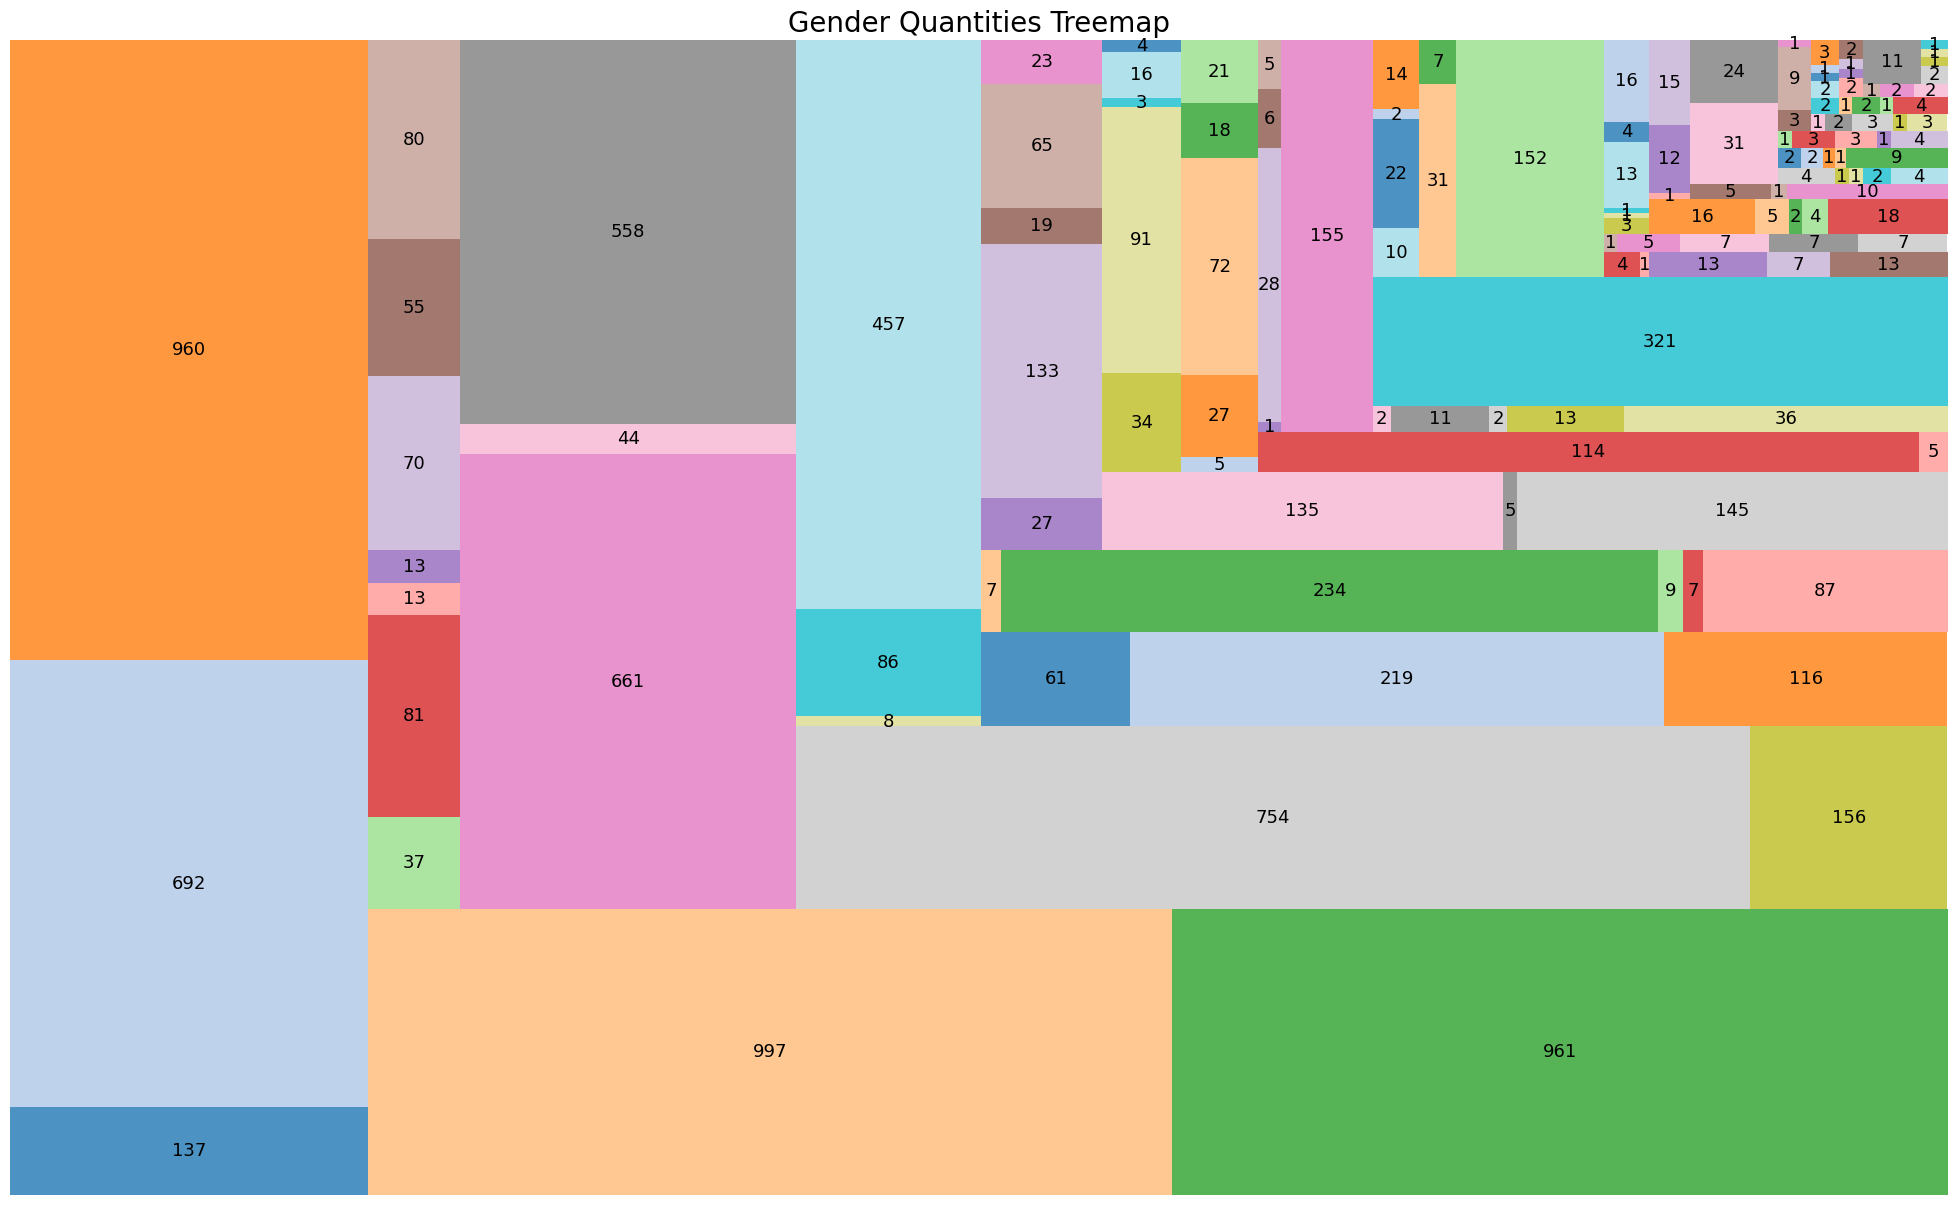

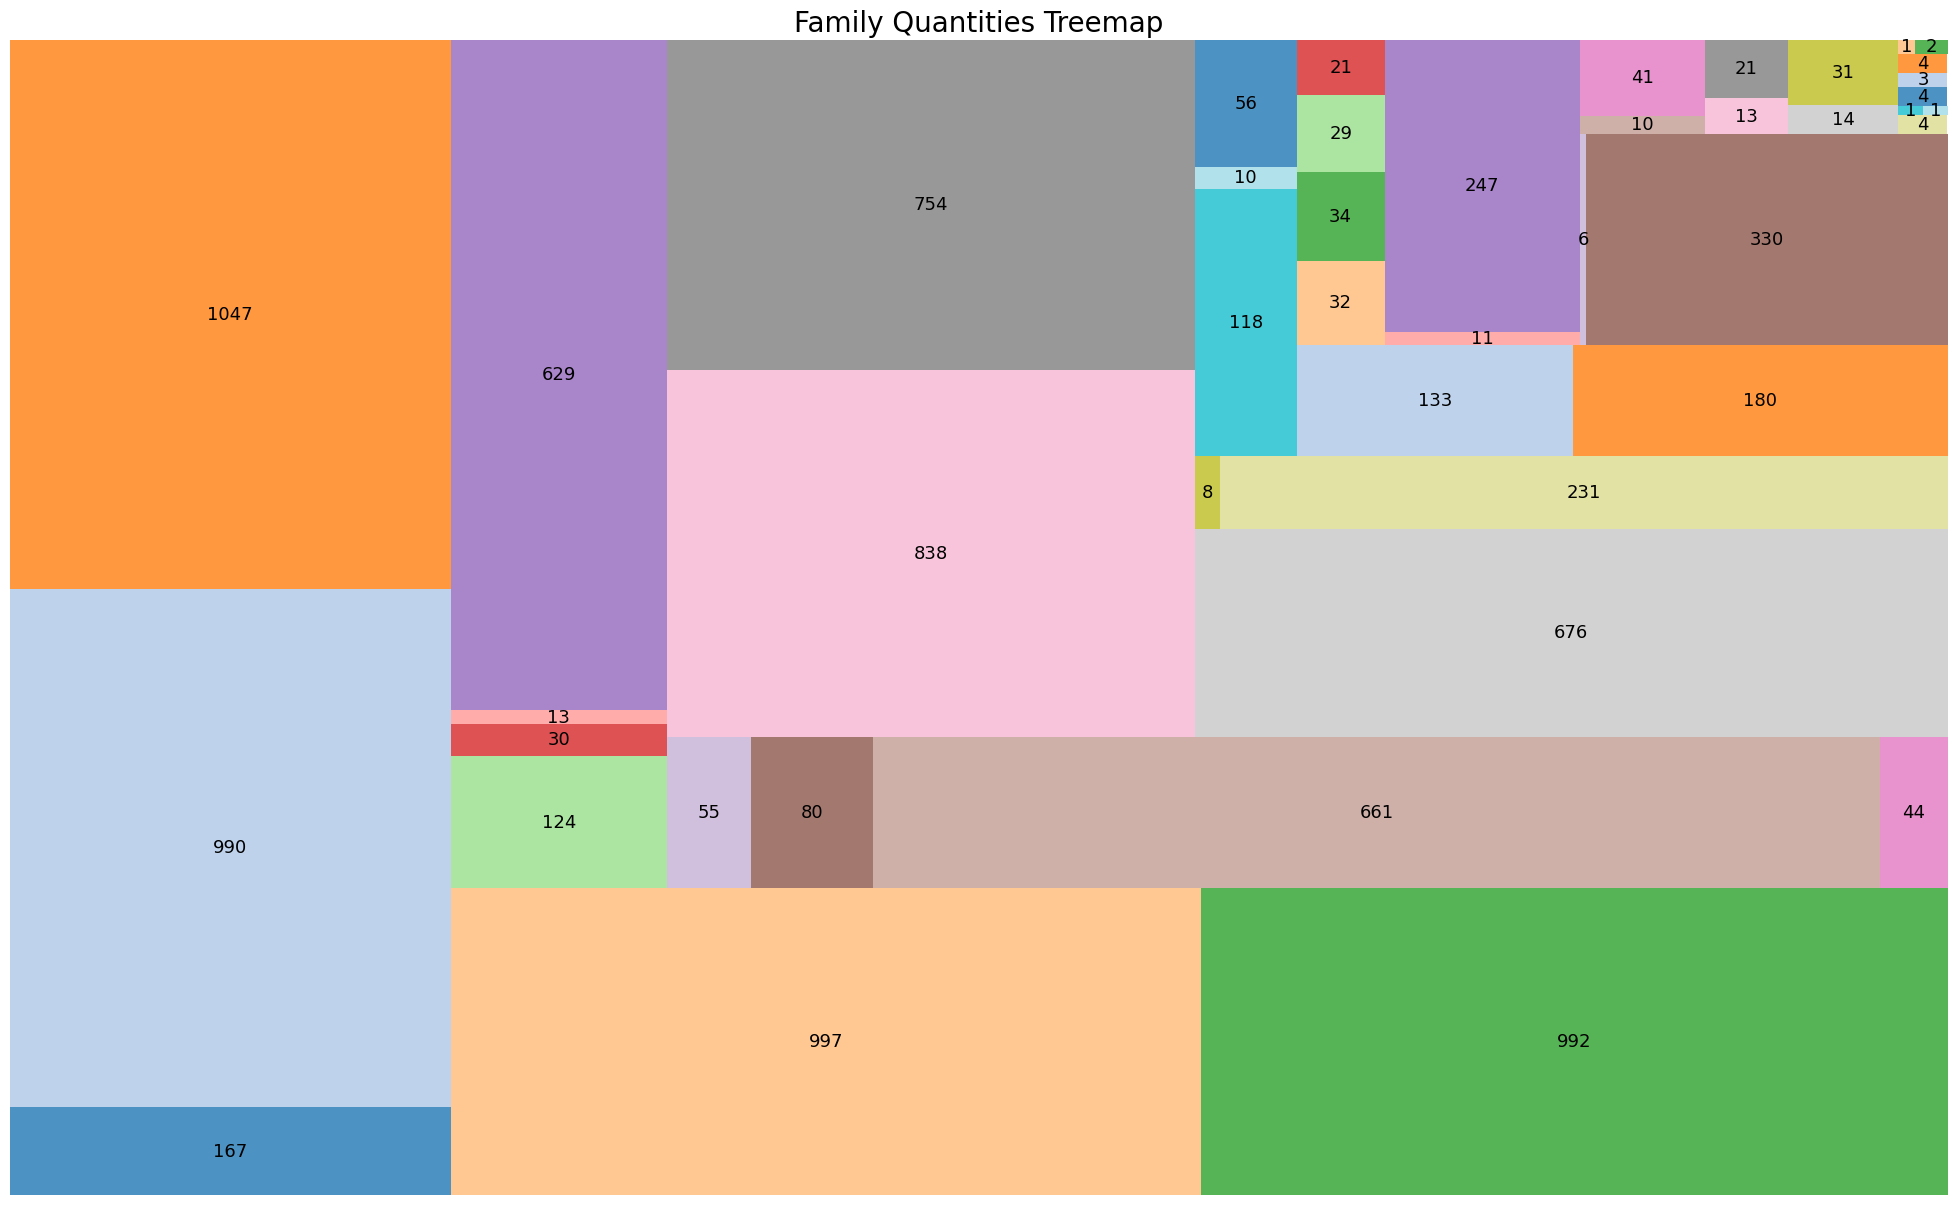

In [29]:
import matplotlib.pyplot as plt
import squarify

def unique_parameters_count(parameters_type, unique_parameters, parameters):
    unique_parameters_count = {type: 0 for type in unique_parameters[parameters_type]}
    for parameter in parameters[parameters_type]:
        unique_parameters_count[parameter] += 1
    return unique_parameters_count


def plot_treemap(unique_parameters_count, parameters_type='Parameters'):
    labels = list(unique_parameters_count.keys())
    sizes = list(unique_parameters_count.values())
    plt.figure(figsize=(25, 15))
    squarify.plot(sizes=sizes, label=sizes, color=plt.cm.tab20.colors, alpha=.8, text_kwargs={'fontsize': 13})
    plt.axis('off')
    plt.title(f'{parameters_type} Quantities Treemap', fontsize=20)
    plt.show()

print(f"Unique Parameters Count: {parameters_count}")
gender_count = unique_parameters_count('gender', unique_parameters, parameters)
plot_treemap(gender_count, parameters_type='Gender')

gender_count = unique_parameters_count('family', unique_parameters, parameters)
plot_treemap(gender_count, parameters_type='Family')


Como podemos ver, el parámetro `genero` presenta multiples muestras menores al 1% de los datos, en comparación al parámetro `familia`.

## Dataset
---
### Preprocesamiento

Dado un tipo de parámetro y con el objetivo de mejorar el rendimiento de nuestro proceso de entrenamiento, necesitamos identificar las clases cuyas cantidades sean menores al 1% de los datos (variable global), para separarlas en una clase general no identificada.

In [8]:
parameter_type = 'gender'
gender_count = unique_parameters_count(parameter_type, unique_parameters, parameters)
n_tree_images = len(data)
threshold = 0.05

def remove_outliers(gender_count, data, n_tree_images, threshold, parameter_type, default_parameter='No Especificado'):
    for parameter, value in gender_count.items():
        if value/n_tree_images < threshold:
            for tree_id, tree_data in data.items():
                if tree_data[parameter_type] == parameter:
                    data[tree_id][parameter_type] = default_parameter
                    # print(f"Parameter {parameter} was removed from tree {tree_id}", data[tree_id][parameter_type])
    return data

filtered_data = remove_outliers(gender_count, data, n_tree_images, threshold, parameter_type)
_, filtered_parameters_count, _ = get_parameters_count(filtered_data)
print(f"Old Parameters Count: {parameters_count[parameter_type]}")
print(f"Filtered Parameters Count: {filtered_parameters_count[parameter_type]}")

Old Parameters Count: 139
Filtered Parameters Count: 8


### Generar Carpetas
Para más adelante realizar validación cruzada debemos separar las imágenes clasificadas en carpetas de entrenamiento, validación y testeo (train, val, test), siguiendo una proporción bien definida (en general 70/20/10).

In [9]:
dataset_folder = images_path.split('/')[-1] + "_arbocensus_dataset_" + parameter_type
up_images_path = '/'.join(images_path.split('/')[:-1])
dataset_folder_path = os.path.join(up_images_path, dataset_folder)
train_p, val_p, test_p = (0.7, 0.2, 0.1)

def create_folder(dataset_folder_path):
    if not os.path.exists(dataset_folder_path): # Si no existe la carpeta la creamos
        os.makedirs(dataset_folder_path)

create_folder(dataset_folder_path)
create_folder(dataset_folder_path + '/train')
create_folder(dataset_folder_path + '/val')
create_folder(dataset_folder_path + '/test')

def segment_tvt(ids_list, tr_p, v_p): # Segmentamos los datos en train, validation y test
    np.random.shuffle(ids_list)
    n = len(ids_list)
    tr_n, v_n = int(n * tr_p), int(n * v_p)
    
    tr_ids = ids_list[:tr_n]
    v_ids = ids_list[tr_n:tr_n + v_n]
    te_ids = ids_list[tr_n + v_n:]
    
    return {'train': tr_ids, 'val': v_ids, 'test': te_ids}

image_folder_ids = segment_tvt(list(filtered_data.keys()), train_p, val_p)

Luego para cada imagen la guardamos en una carpeta con el nombre de su clase.

In [12]:
import shutil
def copy_images(image_folder_ids, target_folder, data, images_path, dataset_folder_path, parameter_type):
    total_images = len(image_folder_ids[target_folder])
    count = 0
    for image_id in image_folder_ids[target_folder]:
        image_path = os.path.join(images_path, image_id)
        if os.path.exists(image_path):
            class_value = data[image_id][parameter_type]
            class_folder = os.path.join(dataset_folder_path, target_folder, class_value)
            create_folder(class_folder)
            new_image_path = os.path.join(class_folder, image_id)
            shutil.copy(image_path, new_image_path)
        else:
            print(f"Image {image_id} not found")
        count += 1
        print(f"Processed image {count}/{total_images}")

copy_images(image_folder_ids, 'train', filtered_data, images_path, dataset_folder_path, parameter_type)
copy_images(image_folder_ids, 'val', filtered_data, images_path, dataset_folder_path, parameter_type)
copy_images(image_folder_ids, 'test', filtered_data, images_path, dataset_folder_path, parameter_type)

Processed image 1/6785
Processed image 2/6785
Processed image 3/6785
Processed image 4/6785
Processed image 5/6785
Processed image 6/6785
Processed image 7/6785
Processed image 8/6785
Processed image 9/6785
Processed image 10/6785
Processed image 11/6785
Processed image 12/6785
Processed image 13/6785
Processed image 14/6785
Processed image 15/6785
Processed image 16/6785
Processed image 17/6785
Processed image 18/6785
Processed image 19/6785
Processed image 20/6785
Processed image 21/6785
Processed image 22/6785
Processed image 23/6785
Processed image 24/6785
Processed image 25/6785
Processed image 26/6785
Processed image 27/6785
Processed image 28/6785
Processed image 29/6785
Processed image 30/6785
Processed image 31/6785
Processed image 32/6785
Processed image 33/6785
Processed image 34/6785
Processed image 35/6785
Processed image 36/6785
Processed image 37/6785
Processed image 38/6785
Processed image 39/6785
Processed image 40/6785
Processed image 41/6785
Processed image 42/6785
P